在卷积神经网络中，感受野（Receptive Field）的定义是卷积神经网络每一层输出的特征图（feature map）上的像素点在输入图片上映射的区域大小。

底部设计基础网络，使它输出的高和宽较大。 这样一来，基于该特征图生成的锚框数量较多，可以用来检测尺寸较小的目标。 接下来的每个多尺度特征块将上一层提供的特征图的高和宽缩小（如减半），并使特征图中每个单元在输入图像上的感受野变得更广阔。

接近网络模型顶部的多尺度特征图较小，但具有较大的感受野，它们适合检测较少但较大的物体。 简而言之，通过多尺度特征块，单发多框检测生成不同大小的锚框，并通过预测边界框的类别和偏移量来检测大小不同的目标，因此这是一个多尺度目标检测模型。

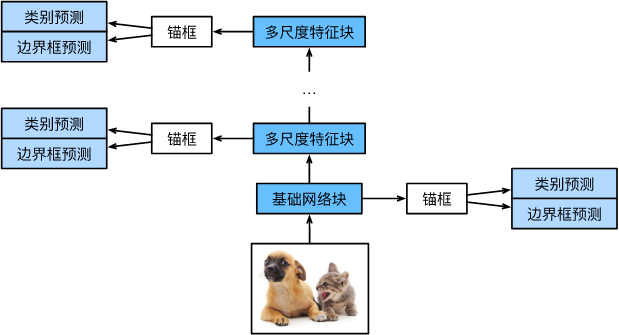

In [ ]:
%matplotlib inline
!pip install d2l
!pip install matplotlib==3.0.0

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
# 类别预测层
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), # 输出通道为锚框数量*(类别数量+1)，+1是因为还有背景类
                     kernel_size=3, padding=1)

In [ ]:
# 边界框预测层
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1) # 输出通道为锚框数量*4，因为每个锚框预测4个偏移量

为了将这两个预测输出链接起来以提高计算效率，我们将把这些张量转换为更一致的格式。

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。 因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的（批量大小，高$\times$宽$\times$通道数）的格式，以方便之后在维度$1$上的连结。

In [ ]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

为了在多个尺度下检测目标，我们在下面定义了高和宽减半块down_sample_blk，该模块将输入特征图的高度和宽度减半。

In [ ]:
# 3*3的卷积层不会改变输入特征图的高宽，2*2的最大汇聚层会使输入特征图的高宽减半
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

基本网络块用于从输入图像中抽取特征。 为了计算简洁，我们构造了一个小的基础网络，该网络串联3个高和宽减半块，并逐步将通道数翻倍。 给定输入图像的形状为$256\times256$，此基本网络块输出的特征图形状为$32 \times 32$（$256/2^3=32$）。

In [ ]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64] # 通道数
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

完整的单发多框检测模型由五个模块组成。每个块生成的特征图既用于生成锚框，又用于预测这些锚框的类别和偏移量。在这五个模块中，第一个是基本网络块，第二个到第四个是高和宽减半块，最后一个模块使用全局最大池将高度和宽度都降到1。从技术上讲，第二到第五个区块都是图中的多尺度特征块。

In [ ]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128) # 通道数翻倍，高宽减半
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1)) # 全局最大池化层
    else:
        blk = down_sample_blk(128, 128) # 通道数不变，高宽减半
    return blk

为每个块定义前向传播。与图像分类任务不同，此处的输出包括：CNN特征图Y；在当前尺度下根据Y生成的锚框；预测的这些锚框的类别和偏移量（基于Y）。

In [ ]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X) # 通过模型网络生成特征图Y
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio) # 生成锚框
    cls_preds = cls_predictor(Y) # 类别预测
    bbox_preds = bbox_predictor(Y) # 偏移值预测
    return (Y, anchors, cls_preds, bbox_preds)

一个较接近顶部的多尺度特征块是用于检测较大目标的，因此需要生成更大的锚框。 在上面的前向传播中，在每个多尺度特征块上，我们通过调用的multibox_prior函数的sizes参数传递两个比例值的列表。 在下面，0.2和1.05之间的区间被均匀分成五个部分，以确定五个模块的在不同尺度下的较小值：0.2、0.37、0.54、0.71和0.88。 之后，他们较大的值由$\sqrt{0.2 \times 0.37} = 0.272$、$\sqrt{0.37 \times 0.54} = 0.447$等给出。

In [ ]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1
num_anchors

4

In [ ]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [ ]:
# 读取数据集
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [ ]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1) # 目标类别只有一种
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

目标检测有两种类型的损失。 第一种有关锚框类别的损失：我们可以简单地复用之前图像分类问题里一直使用的交叉熵损失函数来计算； 第二种有关正类锚框偏移量的损失：预测偏移量是一个回归问题。 但是，对于这个回归问题，我们在这里不使用平方损失，而是使用$L_1$范数损失，即预测值和真实值之差的绝对值。 掩码变量bbox_masks令负类锚框和填充锚框不参与损失的计算。 最后，我们将锚框类别和偏移量的损失相加，以获得模型的最终损失函数。

In [ ]:
# 定义损失函数和损失误差
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks, # 若为正类样本，bbox_masks为1，否则为0
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

由于偏移量使用了$L_1$范数损失，我们使用平均绝对误差来评价边界框的预测结果。这些预测结果是从生成的锚框及其预测偏移量中获得的。

In [ ]:
# 求分类正确的个数
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

在训练模型时，我们需要在模型的前向传播过程中生成多尺度锚框（anchors），并预测其类别（cls_preds）和偏移量（bbox_preds）。 然后，我们根据标签信息Y为生成的锚框标记类别（cls_labels）和偏移量（bbox_labels）。 最后，我们根据类别和偏移量的预测和标注值计算损失函数。

class err 3.25e-03, bbox mae 3.25e-03
584.2 examples/sec on cpu


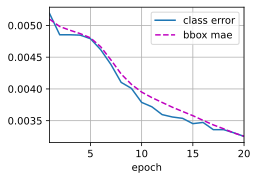

In [ ]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

## 预测目标

In [ ]:
X = torchvision.io.read_image('/content/sample_data/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [ ]:
# 根据锚框及其预测偏移量得到预测边界框。然后，通过非极大值抑制来移除相似的预测边界框。
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

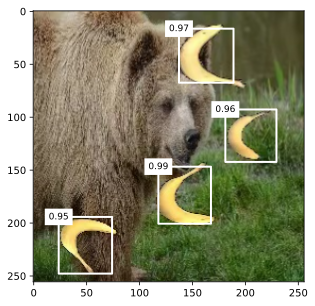

In [ ]:
# 筛选所有置信度不低于0.9的边界框，做为最终输出。
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)